# COMP90051 Workshop 6
## Convolutional Neural Networks
***
In this worksheet, we'll implement a convolutional neural network (CNN) in Keras—a high-level API for deep learning. 
Since this is our first time using Keras, we'll start by implementing logistic regression—a familiar model from workshop 4. 
We'll then extend logistic regression to build a CNN by adding 2D convolutional and max-pooling layers.
By the end of this worksheet, you should be able to:
* define and fit models in Keras
* explain the architecture of a basic CNN

Let's begin by importing the required packages.

In [1]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.1.0


## 1. MNIST dataset

MNIST is a multi-class classification data set where:
* the features are images of handwritten digits (28×28 pixels with a single 8-bit channel)
* the target is a label in the set $\{0, 1, \ldots, 9\}$

The data is already split into training and test sets. The training set contains 60,000 instances and the test set contains 10,000 instances.

Below we load the data into NumPy arrays using a built-in function from Keras.

***
**Question:** How are the arrays structured? Which index is used to access individual instances? What is the type of the arrays? 

_Hint: use `array.dtype` to check._

_Answer:_ The 0th axis indexes instances, the 1st axis indexes rows of pixels and the 2nd axis indexes columns of pixels.
***

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print("train_images shape:", train_images.shape)
print("test_images shape:", test_images.shape)

train_images shape: (60000, 28, 28)
test_images shape: (10000, 28, 28)


Before using the data for logistic regression, we need to do some basic pre-processing: 
 * We rescale the images so that each pixel is represented as a float between 0 and 1 (note that the images are already normalised)
 * Ensure that the final array axis indexes the channel. For colour images, there are typically three channels corresponding to R, G, B. However, in this example we only have a single greyscale channel.

In [3]:
# Rescale
train_images = train_images.astype(float) / 255
test_images = test_images.astype(float) / 255

train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)
print("train_images shape:", train_images.shape)
print("test_images shape:", test_images.shape)

train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)


The code block below visualises random examples from the training set.

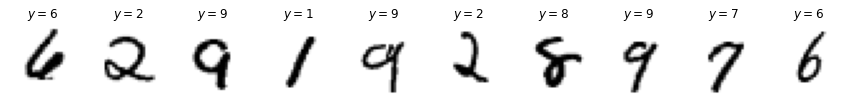

In [4]:
num_images = 10
fig, axes = plt.subplots(figsize=(1.5*num_images, 1.5), ncols=num_images)
sample_ids = np.random.choice(train_images.shape[0], size=num_images, replace=False)
for i, s in enumerate(sample_ids):
    axes[i].imshow(train_images[s,:,:,0], cmap='binary')
    axes[i].set_title("$y = {}$".format(train_labels[s]))
    axes[i].axis('off')
plt.show()

Finally, we note that the training set is relatively balanced—there are roughly 6000 examples for each digit.

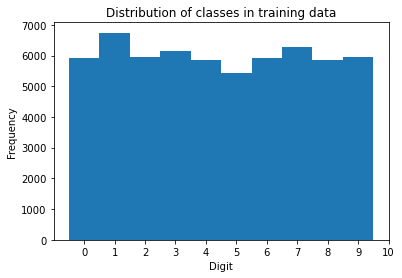

In [5]:
plt.hist(train_labels, bins=range(11), align='left')
plt.xticks(ticks=range(11))
plt.title('Distribution of classes in training data')
plt.ylabel('Frequency')
plt.xlabel('Digit')
plt.show()

## 2. Multi-class logistic regression

The handwritten digit recognition task is an example of a _multi-class_ classification problem. 
There are 10 classes—one for each digit $0, 1,\ldots, 9$.
We'll first tackle the problem by generalising binary logistic regression (from workshop 4), to handle _multiple classes_.

Let the classes be denoted by integers $\{1, \ldots, C\}$ (in our example $C = 10$).
Treating class $C$ as a "reference", we assume a linear relationship between the feature vector $\mathbf{x} \in \mathbb{R}^d$ and the log-odds of each class:

$$
\log \frac{p(y = c|\mathbf{x})}{p(y = C|\mathbf{x})} = \mathbf{x}^\top \mathbf{w}_c + b_c
$$

where $\mathbf{w}_c \in \mathbb{R}^d$ and $b_c \in \mathbb{R}$ are the weights and bias for class $c$.

We can write this more compactly as

$$
\begin{gather}
    p(y = c|\mathbf{x}) = \operatorname{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b})_c = \frac{\exp \left\{-(\mathbf{W} \mathbf{x} + \mathbf{b})_c \right\}}{\sum_{c' = 1}^{C} \exp \left\{-(\mathbf{W} \mathbf{x} + \mathbf{b})_{c'} \right\}}
\end{gather}
$$

where $\mathbf{W} = [\mathbf{w}_1, \ldots, \mathbf{w}_C]^\top$ and $\mathbf{b} =[b_1, \ldots, b_C]^\top$.

This model can be expressed in Keras as follows.

In [6]:
lr = keras.Sequential(
    [
        layers.Input((28,28,1)),               # Tell Keras the shape of the input array (a single-channel 28×28 image)
        layers.Flatten(),                      # Unravel/flatten the input array
        layers.Dense(10, activation='softmax') # Add a fully-connected layer with a softmax activation function
    ]
)

Next, we have to specify a loss function.
As for binary logistic regression, we use the cross-entropy loss or log-loss:

$$
\ell_\mathrm{log}(y, \boldsymbol{\pi}) = - \sum_{c = 1}^{C} \mathbb{1}[y = c] \log \pi_c
$$

where $\mathbb{1}[\cdot]$ is the indicator function and $\pi_c = \operatorname{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b})$ is the estimate for $p(y = c|\mathbf{x})$.

The following code block prepares the `lr` model for training under the cross-entropy loss.
It sets [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) (Adaptive Moment Estimation) as the optimisation algorithm and directs Keras to keep track of accuracy during training.

In [7]:
lr.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
           metrics=['accuracy'])

We're now ready to fit the `lr` model using the training data. 
By setting `batch_size = 100`, each gradient descent step is computed w.r.t. a random batch of 100 training instances.
By setting `epochs = 20`, we loop over the complete training data 20 times.

In [8]:
history_lr = lr.fit(train_images, train_labels, epochs=20, batch_size=100, 
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.6259 - accuracy: 0.8462 - val_loss: 0.3609 - val_accuracy: 0.9048
Epoch 2/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.3449 - accuracy: 0.9062 - val_loss: 0.3073 - val_accuracy: 0.9150
Epoch 3/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3090 - accuracy: 0.9148 - val_loss: 0.2881 - val_accuracy: 0.9187
Epoch 4/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2925 - accuracy: 0.9185 - val_loss: 0.2785 - val_accuracy: 0.9223
Epoch 5/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.2822 - accuracy: 0.9218 - val_loss: 0.2731 - val_accuracy: 0.9236
Epoch 6/20
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2751 - accuracy: 0.9230 - val_loss: 0.2717 - val_accuracy: 0.9244
Epoch 7/20
60000/60000 [==============================] 

The plots below show that the model fit is unlikely to improve significantly with further training. 
Both the test loss and accuracy have flattened out.

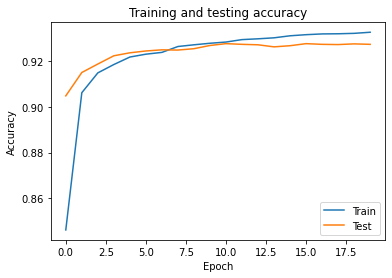

In [9]:
plt.plot(history_lr.history['accuracy'], label='Train')
plt.plot(history_lr.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

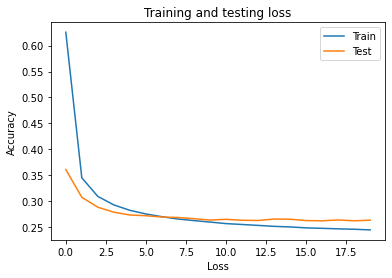

In [10]:
plt.plot(history_lr.history['loss'], label='Train')
plt.plot(history_lr.history['val_loss'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Loss')
plt.title('Training and testing loss')
plt.legend()
plt.show()

## 3. Convolutional neural network (CNN)

Let's see if we can improve on logistic regression using a CNN.

For the convolutional layers, we follow the "convolutional pyramid" design principle—i.e. successive layers have decreasing spatial dimensions, but increasing depth. The reduction in the spatial dimensions is achieved via max pooling.

After the convolutional layers, we add a densely-connected layer (effectively a logistic regression layer) which combines the higher-level features to make a classification.
We also make use of [dropout](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) (a regularization method whereby random units are removed from the network) to prevent overfitting.

<svg height="210" width="500">
  <polygon points="200,10 250,190 160,210" style="fill:lime;stroke:purple;stroke-width:1" />
</svg>

### Architecture overview

We describe the architecture in further detail below (figure generated [here](http://alexlenail.me/NN-SVG/AlexNet.html)).

CNN architecture

| Number | Layer type    | Specification                                                                           | Keras function |
|--------|---------------|-----------------------------------------------------------------------------------------|----------------|
| 1      | Convolutional | 8 5×5 filters with a stride of 1 and a ReLU activation function                         | Conv2D         |
| 2      | Pooling       | Max pooling with a 2×2 filter and a stride of 2 (implies pooled regions do not overlap) | MaxPooling2D   |
| 3      | Convolutional | 16 5×5 filters with a stride of 1 and a ReLU activation function                        | Conv2D         |
| 4      | Pooling       | Same specs as pooling layer #1                                                          | MaxPooling2D   |
| 5      | Flatten       | Nil                                                                                     | Flatten        |
| 6      | Dropout       | Randomly drops a fraction $r$ of the input units. We set $r=0.5$.                       | Dropout        |
| 7      | Dense         | 10 units (one for each target class) with a softmax activation function.                | Dense          |

***
**Exercise:** Complete the code block below to instantiate the model in Keras. 

_Hint: you can check the documentation for a layer type (e.g. Conv2D) by entering `?layers.Conv2D`._
***

In [11]:
cnn = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        layers.Conv2D(8, (5, 5), activation='relu'), # fill in
        layers.MaxPooling2D((2, 2)), # fill in
        layers.Conv2D(16, (5, 5), activation='relu'), #fill in
        layers.MaxPooling2D((2, 2)), # fill in
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ], 
)

We can get a useful summary of the model architecture using the `summary` method, as shown below.

In [12]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

***
**Question:** How many trainable parameters are there in the `cnn` model? How does this compare with the earlier `lr` model?

_Answer:_ The `cnn` model has 5,994 parameters, while the `lr` model has 7,850 parameters. However, the `lr` model is more limited in the functions it can represent as it is a shallow (single-layer) network.
***

We prepare the `cnn` model for training using the same settings as for logistic regression.

In [13]:
cnn.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

Training the `cnn` model takes roughly 20 times longer than training the `lr` model on a CPU. 
You may like to set the number of epochs to a smaller number (e.g. `epochs=10`) if you don't have much time to spare.

In [14]:
history_cnn = cnn.fit(train_images, train_labels, epochs=20, batch_size=100, 
                      validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 18s 302us/sample - loss: 0.6029 - accuracy: 0.8064 - val_loss: 0.1441 - val_accuracy: 0.9579
Epoch 2/20
60000/60000 [==============================] - 20s 339us/sample - loss: 0.2215 - accuracy: 0.9321 - val_loss: 0.0936 - val_accuracy: 0.9716
Epoch 3/20
60000/60000 [==============================] - 20s 327us/sample - loss: 0.1659 - accuracy: 0.9491 - val_loss: 0.0704 - val_accuracy: 0.9793
Epoch 4/20
60000/60000 [==============================] - 22s 373us/sample - loss: 0.1442 - accuracy: 0.9556 - val_loss: 0.0605 - val_accuracy: 0.9813
Epoch 5/20
60000/60000 [==============================] - 20s 335us/sample - loss: 0.1273 - accuracy: 0.9617 - val_loss: 0.0556 - val_accuracy: 0.9826
Epoch 6/20
60000/60000 [==============================] - 20s 330us/sample - loss: 0.1159 - accuracy: 0.9647 - val_loss: 0.0506 - val_accuracy: 0.9844
Epoch 7/20
60000/60000 [====================

Let's plot the accuracy and loss for each epoch, like we did for logistic regression.

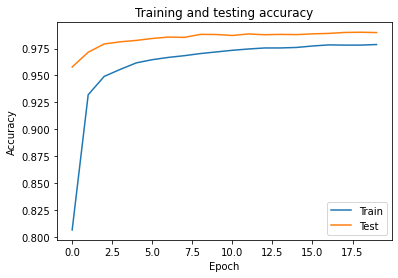

In [15]:
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

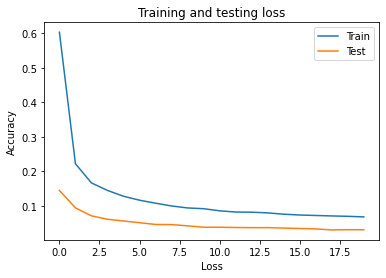

In [16]:
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Loss')
plt.title('Training and testing loss')
plt.legend()
plt.show()

Both the training accuracy and loss appear to have stabilised, so it's unlikely the model will benefit from further epochs.

***
**Question:** Which model performs best for MNIST digit recognition? 

_Answer:_ The CNN achieves a test accuracy of around 0.99. 
This is a significant improvement over logistic regression, which achieved a test accuracy of around 0.93.
This is to be expected as the CNN architecture naturally suited to vision applications—it takes advantage of local spatial coherence in images.
***

## Bonus: Visualising filters (optional)

CNNs learn filters that extract salient features from images, as they pass through the network. 
To understand how a CNN operates, it can be interesting to visualise the filters and their activations on input images.

First, let's examine the layers in the `cnn` model.

In [18]:
cnn.layers

We'll take a look at the filters in the first convolutional layer, which is at index 0 in the list of layers.
The `get_weights` method extracts the weights as numpy arrays.

In [19]:
filters, biases = cnn.layers[0].get_weights()
print("filters.shape:", filters.shape)

filters.shape: (5, 5, 1, 8)


Below we visualise the 8 single-channel filters in the first convolutional layer. 
It's often possible to recognise filters that detect different types of strokes, e.g. diagonal, vertical etc. 
The specific filters learned may vary due to stochasticity in the weight initialisation and optimisation algorithm.

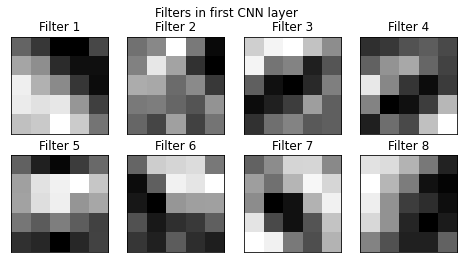

In [20]:
fig, axes = plt.subplots(figsize=(8,4), nrows=2,ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filters[:,:,0,i], cmap='binary')
    ax.set_title("Filter {}".format(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('Filters in first CNN layer')
plt.show()

We can also improve our understanding by examining the intermediate outputs of internal layers of the CNN. 
In the code block below, we demonstrate how to access the output of the first convolutional layer (with index 0). \[Aside: you may like to visualise the output of deeper layers by changing the index.\]

Specifically, we define a new model that reuses the input of the `cnn` model, but truncates the output to the 0th layer.

In [21]:
cnn_internal = keras.Model(inputs=cnn.input, outputs=cnn.layers[0].output)

We then pass a single training example through the truncated model.

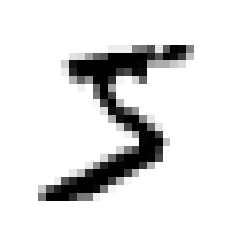

In [22]:
# Get the first example from the training set
training_example = np.expand_dims(train_images[0], 0)
plt.imshow(training_example[0,:,:,0], cmap='binary')
plt.axis('off')

# Pass through the `cnn_internal` model
activations = cnn_internal.predict(training_example)

After passing an image through the first layer, we end up with an array of 8 24×24 single-channel images (one image for each filter). 
We can see that each filter is active on different parts of the image. 
For example in this particular run, the first filter is activating on diagonal strokes at the bottom-left edge.

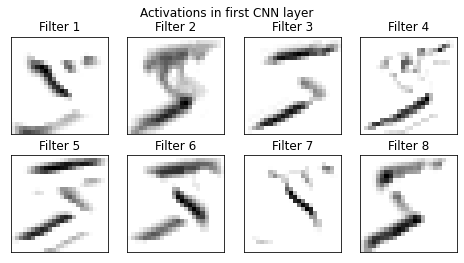

In [23]:
fig, axes = plt.subplots(figsize=(8,4), nrows=2,ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(activations[0,:,:,i], cmap='binary')
    ax.set_title("Filter {}".format(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('Activations in first CNN layer')
plt.show()